# Yule-Simon Processes for Time Series Modeling & Analysis

## 1. Introduction
This notebook outlines how to do time series inference using the Yule-Simon process as a prior. We first introduce some preliminary concepts, then fetch stock price data from Yahoo finance, and then apply Markov-Chain Monte Carlo (MCMC) to sample the Yule-Simon process posterior. We then analyze the results and evaluate converenge, check the model fit, and compute expectations for the latent variables.

## 2. Preliminaries
Before we get started, we will briefly touch on some preliminary concepts.

### 2.1 The Yule-Simon Model
The Yule-Simon model is named after the work of George Udny Yule and Herbert Simon on power-law distributions. Yule formulated the initial model in 1922 for the frequency distribution of biological genera (i.e. the number of species in a genus) and Simon later used the model (via an alternate path in 1955) for the word frequency distribution of text (a.k.a. Zipf's law). Both of which follow power-law distributions. 

### 2.2 Power-Law Distributions
Power law distributions are probability distributions with very long tails which have the following form:

$p(x) = \frac{1}{Z}x^{-\alpha}, \quad x>x_{min}>0$

where $\alpha$ is known as the power-law exponent (for obvious reasons) and $Z$ is the normalizing constant. Power laws appear in many places including the size of cities, income distributions, and degree distribution of webpages. The Yule-Simon model has the following probability mass function:

$p(k) = \alpha B(k,\alpha+1)$

where $B(x,y)$ is the beta function. This converges to the standard power-law distribution for large $k$. To get a better intuition, lets plot this distribution on linear and log scales for some different values of $\alpha$:

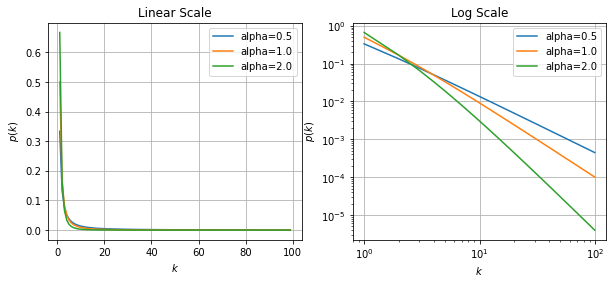

In [1]:
# Import Modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta

# Create Inline PDF Function
yulesimon_pdf = lambda k,alpha: alpha * beta(k,alpha+1)

# Plot Yule-Simon Distribution for Different Values of Alpha
support = np.arange(1,1e2)
alpha = np.array([0.5,1,2])
fig, ax = plt.subplots(1,2)
for ii in range(len(alpha)):
    ax[0].plot(support,yulesimon_pdf(support,alpha[ii]),label='alpha='+str(alpha[ii]))
    ax[1].loglog(support,yulesimon_pdf(support,alpha[ii]),label='alpha='+str(alpha[ii]))

ax[0].grid(True), ax[0].set_title('Linear Scale'), ax[0].set_xlabel('$k$'), ax[0].set_ylabel('$p(k)$'), ax[0].legend()
ax[1].grid(True), ax[1].set_title('Log Scale'), ax[1].set_xlabel('$k$'), ax[1].set_ylabel('$p(k)$'), ax[1].legend()
fig.set_size_inches(10,4)
plt.show()

From these plots we can see the tail of the Yule-Simon distribution is (almost) linear when we plot the log-log scale. This is a tell tale sign of a power law distribution. The implication of this result is that when we draw samples from this distribution, the majority of the values will be small but a some will be gigantic. The value of $\alpha$ controls how heavy the tail is.

### 2.3 Time Series Modeling
To apply the Yule-Simon concept to time series modeling, let us assume we would like to randomly generate a time series of length $N$. Furthermore, we would like to partition this sequence into subsequences of length $n_k \leq N$ where each subsequence exhibits (potentially) different properties. To allow for extreme events and behavior of this time series, we can assign a Yule-Simon prior to the size of each time series segment $n_k$. This will have the effect of creating long runs of consistent behavior punctuated by abrupt changes.

This idea is very general, so let's focus on particular case. We will assume the time series is a white noise process where each subsegment has a random mean and variance. We will assume the mean $\mu$ follows a random walk and the precision $\lambda$ (inverse variance) is independently sampled from a gamma distribution in each subsegment. This can be expressed by the following stochastic process:

$n_k|\alpha \sim \text{YuleSimon}(\alpha)$

$\lambda_k|a,b \sim \text{Gamma}(a,b)$

$\mu_t|Q \sim \text{Gaussian}(\mu_{t-1},Q)$

$y_t|\mu_t,\lambda_{x_t} \sim \text{Gaussian}(\mu_t,\lambda_{x_t}^{-1})$

where $x_t$ is the time series partition on the $t^{th}$ sample (assuming $t$ is discrete), and $y_t$ is the observed time series data. Let's simulate this process to get a better idea of what a sample realization looks like:

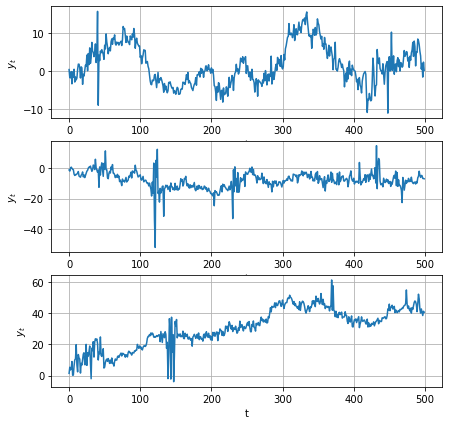

In [2]:
# Import Yule-Simon Module
import yulesimon as ys

# Create/Plot 3 Sample Realizations
fig, ax = plt.subplots(3)
for ii in range(3):
    y,x,lambdas,mu = ys.GaussianNoiseProcess(N=500, alpha=1.0, a=0.7, b=1.0, Q=1.0, seed=12+10*ii)
    ax[ii].plot(y)
    ax[ii].grid(True), ax[ii].set_xlabel('t'), ax[ii].set_ylabel('$y_t$')
fig.set_size_inches(7,7)
plt.show()

We can see this process is quite expressive. Just drawing 3 realizations with the same parameters and different random seeds produces quite different results. The trend variation can be controlled by changing $Q$, the noise statistics can be controlled by modifying $a$ and $b$, and the partition disitribution can be controlled by varying $\alpha$. 

### 2.4 Inference
The inference problem is to recover the latent (i.e. hidden) model variables given only the time series $y_t$. One way to do this is to compute the model posterior distribution conditioned on the sequence $y_t$:

$p(n_{1:L},\mu_{1:N},\lambda_{1:L}|y_{1:N},\alpha,a,b,Q) = \frac{1}{Z}p(y_{1:N}|n_{1:L},\mu_{1:N},\lambda_{1:L})p(n_{1:L},\mu_{1:N},\lambda_{1:L}|\alpha,a,b,Q)$

where the notation $n_{1:L}$ denotes all samples from $1$ to $L$ (assuming $L$ partitions). There are a couple problems that arise immediately -- first of all this calculation is intractable due to the size of the state space. Second there are several hyperparameters $(\alpha, a, b, Q)$ which we do not know that can lead to very different solutions. To tackle these problems, we will use Markov Chain Monte Carlo (MCMC) to draw samples from the Yule-Simon process posterior and then compute numerical expectations of the latent model variables. In doing so we will also assign hyperpriors to the unknown hyperparameters and sample their values simultaneouly:

$\alpha \sim \text{Gamma}(1,1)$

$a,b \sim \pi(1,0,0,0)$

$Q \sim \text{Gamma}(1,1)$

where,

$\pi(a,b|p,q,r,s) \propto p^{a-1}e^{-bq}b^{as}\Gamma(a)^{-r}$

is the conjugate prior to the gamma distribution when both parameters are unknown. 

The idea behind MCMC is to simulate a Markov chain with the same target distribution as the posterior we are interested in sampling from. The strategy is to initialize the Markov chain with a reasonable guess, then let the chain converge to the posterior during what's called a "burn-in" period. Once converged, the states of the chain can be used as posterior samples. 

## 3. Reading the Data
Next we will read 5 years of Microsoft daily closing prices from Yahoo finance:

In [3]:
security = 'MSFT'
nyears = 5
closing_prices, log_returns, dates = ys.GetYahooFeed(security,nyears)

Rather than working with the daily closing prices $p_t$ themselves, we will work with the daily log returns $r_t$ defined by:

$r_t = \log p_t - \log p_{t-1}$ 

Let's plot both and take a look:

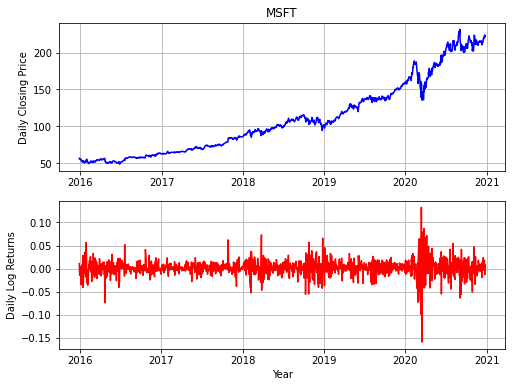

In [4]:
fig,ax = plt.subplots(2)
ax[0].plot(dates,closing_prices,color='b')
ax[0].grid(True)
ax[0].set_ylabel('Daily Closing Price')
ax[0].set_title(security)
ax[1].plot(dates[1:],log_returns,color='r')
ax[1].grid(True)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Daily Log Returns')
fig.set_size_inches(8,6)
plt.show()

## 4. Running Inference Algorithm
To run the MCMC inference algorithm, we begin by creating a Yule-Simon TimeSeries object:

In [5]:
Chain = ys.TimeSeries(log_returns)

Next we will run the Markov chain for 1000 steps (this may take a couple minutes):

In [ ]:
nsteps = 1000
history = Chain.step(nsteps)

..........................................................................

## 5. Analysis
Next we will take a look at the results and assess convergence, model fit, and latent variable expectations.

### 5.1 Convergence
To assess convergence, we begin by inspecting the log-likelihood as a function of MCMC iteration:

In [ ]:
fig,ax = plt.subplots()
ax.plot(history.log_likelihood)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-Likelihood')
ax.grid(True)
fig.set_size_inches(5,4)
plt.show()

Based on the large initial step, the Markov chain appears to have mixed very fast and reached the posterior within a few steps. Next let's take a look at the hyperparameter samples for $\alpha, a, b,$ and $Q$:

In [ ]:
fig,ax = plt.subplots(1,4)
ax[0].plot(history.process_noise) 
ax[0].grid(True)
ax[0].set_title('Q')
ax[0].set_xlabel('Iteration')
ax[1].plot(history.alpha)
ax[1].grid(True)
ax[1].set_title('alpha')
ax[1].set_xlabel('Iteration')
ax[2].plot(history.hyperparameter_a0)
ax[2].grid(True)
ax[2].set_title('a')
ax[2].set_xlabel('Iteration')
ax[3].plot(history.hyperparameter_b0)
ax[3].grid(True)
ax[3].set_title('b')
ax[3].set_xlabel('Iteration')
fig.set_size_inches(14,3)
plt.show()

Here we see similar results. The hyperparameters $Q$ and $\alpha$ each have their own MCMC samplers which are updated after the main MCMC sampler for sampling the Yule-Simon partitions. Each of these uses a Gibbs sampler. The $[a,b]$ hyperpriors are sampled using a Metropolis-Hastings sampler which may reject steps depending on the proposal distribution. Whereas with Gibbs sampling each step is always accepted. We can clearly see this in these plots.

### 5.2 Model Fit
Next we will inspect the p-values as a function of MCMC iteration. Because the assumed model is a Gaussian noise process with time varying mean and variance, if we correctly estimate the mean and variance we should be able to standardize the observed time series to a zero mean, unit variance i.i.d. (independent and identically distributed) sequence using:

$z_t = \frac{y_t - \mu_t}{\sigma_t}$

We can then do a hypothesis test on $z_t$ for normality. The p-value is the probability of observing the test result under the null (i.e. normal) hypothesis. Therefore, if we have done a good job estimating the mean and variance we should see a high p-value, ideally close to 1. After each MCMC iteration, the current state of the time varying mean and variance is used to standardize the observed time series and run a goodness of fit test. 

Let's plot the p-values:

In [ ]:
fig,ax = plt.subplots()
ax.semilogy(history.pvalue[1:])
ax.set_xlabel('Iteration')
ax.set_ylabel('p-Values')
ax.grid(True)
fig.set_size_inches(5,4)
plt.show()

Here we can see the p-values follow a similar pattern as the log-likelihood, initially starting low and then gradually approaching 1.0 as Markov chain converges to the posterior distribution. In terms of statistical hypothesis testing, this is considered a weak conclusion as we have only failed to reject the Gaussian hypothesis. This doesn't prove we have correctly estimated the time varying mean and variance.

Another thing we can do is plot the standardized time series against the quantiles of the Gaussian distribution. To do so we will first compute the expected values of mean and variance processes using the ExpectedValue routine. We will set the burn-in period to half the number of MCMC steps and downsample by a factor of 10 (i.e. only keep every 10th sample). We will also only take samples with p-value > 0.2:

In [ ]:
burnin = nsteps/2
downsample = 10
sigma_t, sample_size = ys.ExpectedValue(history.std_deviation,burnin,downsample,history.pvalue>0.2)
mu_t, sample_size = ys.ExpectedValue(history.mean,burnin,downsample,history.pvalue>0.2)

Next we will standardize the observations and plot them using the scipy routine probplot:

In [ ]:
from scipy.stats import probplot
fig, ax = plt.subplots(2,2)
res = probplot(log_returns/np.std(log_returns), plot=ax[0,0])
res = probplot((Chain.data-mu_t)/sigma_t, plot=ax[0,1])
ax[1,0].plot(log_returns/np.std(log_returns))
ax[1,1].plot((Chain.data-mu_t)/sigma_t)
ax[0,0].set_title('Observed Data')
ax[0,0].grid(True)
ax[0,1].set_title('Standardized Data '+'(N='+str(sample_size)+')')
ax[0,1].grid(True)
ax[1,0].grid(True), ax[1,0].set_xlabel('Sample'), ax[1,0].set_ylabel('Observed $r_t$')
ax[1,1].grid(True), ax[1,1].set_xlabel('Sample'), ax[1,1].set_ylabel('Standardized $r_t$')
fig.set_size_inches(10,10)
plt.show()

From this we can clearly see the standardization has completely removed the heavy tails from from the observations.

### 5.3 Latent Variable Estimates
Next we will inspect the mean and variance sequences and then conclude with an estimate of the unconditional log return mixture distribution

### 5.3.1 Variance Process
Here we will plot the expected standard deviation sequence over the observed time series data. Recall this estimate is accumulated over multiple samples. To get some insight on the partition samples, we will also plot the partition boundaries as a heatmap:

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(dates[1:],log_returns,label='log returns: $r_t$')
ax[0].plot(dates[1:],+2 * sigma_t/100,label='$r_t+2\sigma_t$')
ax[0].plot(dates[1:],-2 * sigma_t/100,label='$r_t-2\sigma_t$')
ax[0].grid(True)
ax[0].autoscale(tight=True)
ax[0].set_xlabel('Date')
ax[0].legend()

ax[1].imshow(np.transpose(history.boundaries))
ax[1].set_aspect('auto')
ax[1].set_ylabel('Iteration')
ax[1].set_title('Partition Boundary Heatmap')
ax[1].set_yticks([])
ax[1].set_xticks([])
fig.set_size_inches(10,10)
plt.show()


Each row of the heatmap represents an MCMC iteration and the light blue values indicate there is a boundary. We can see the appearance of vertical lines indicating a high probability of partition boundary. 

### 5.3.2 Mean Process
Here we plot the mean process over the observed log return sequence. Interestingly we see a positive mean process even through Covid-19 crash in the early part of 2020. The mean apparently corresponds to the overall trend of the daily closing prices while the ups and downs seem to be caused by the switching variance process. 

In [ ]:
fig,ax = plt.subplots()
ax.plot(dates[1:],log_returns,'r',label='log returns: $r_t$')
ax.plot(dates[1:],mu_t/100,'tab:blue',label='$E[r_t]$')
ax.plot(dates[1:],mu_t*0,'k--',label='zero ref.')
ax.grid(True)
ax.set_xlabel('Year')
ax.set_ylabel('Log Returns')
ax.set_ylim([-0.05,0.05])
fig.set_size_inches(10,6)
plt.legend()
plt.show()

### 5.3.3 Mixture Model
Finally we will compute the unconditional log-return mixture distribution using our estimates of the mean and variance processes. To do so we set up a vector of support values, then call the MixtureModel routine:

In [ ]:
z = np.arange(-0.2,0.2,0.001)
yulesimon_PDF = ys.MixtureModel(z,mu_t/100,sigma_t/100)

For comparison we will compare this result to the empirical log return PDF and a standard Gaussian PDF with the empirical log return variance:

In [ ]:
# Empirical PDF
H,b = np.histogram(log_returns,200)
delta = b[1]-b[0]
bctr = b[1:]-delta/2.0
empirical_PDF = H/(sum(H)*delta)

# Gaussian PDF
gaussian_PDF = ys.Gaussian(z,np.mean(log_returns),1/np.var(log_returns))

Next let's make the figure:

In [ ]:
fig,ax = plt.subplots()
ax.semilogy(bctr,empirical_PDF,label='Empirical')
ax.semilogy(z,yulesimon_PDF,label='Yule-Simon')
ax.semilogy(z,gaussian_PDF,label='Gaussian')
ax.grid(True)
ax.set_xlabel('Log Returns')
ax.set_ylabel('PDF')
ax.set_ylim([1e-10,1e2])
fig.set_size_inches(8,6)
plt.legend()
plt.show()

The Yule-Simon model is clearly a better fit than the Gaussian, however evaluating the tails is tricky due to the low frequency of tail events.

## 6. Conclusion
In this notebook we outlined how to use the Yule-Simon process as a prior for time series analysis, in particular for the case of univariate time series with time varying mean and variance processes. We evaluated the Yule-Simon prior process using five years of daily log returns from Yahoo finance. in doing so we performed inference using MCMC and described how to evaluate convergence and model fit. We then described how to compute numerical expectations of the mean and variance processes and create a mixture model.